<a href="https://colab.research.google.com/github/byui-cse/cse480-notebooks/blob/master/07_2_Calculator_with_Parse_Tree_Drawing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculator with Parse Tree Drawing
## Class Directed Learning
### Due: Thursday, 18 February 2021, 11:59 pm

## Imports first, then assignment

In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import sys

# -- Detect if in Own Install or in Colab
try:
    import google.colab
    OWN_INSTALL = False
except:
    OWN_INSTALL = True
    
if OWN_INSTALL:

  sys.path[0:0] = ['../../../../..',  '../../../../../3rdparty',  
                   '../../../..',  '../../../../3rdparty',  
                   '../../..',     '../../../3rdparty', 
                   '../..',        '../../3rdparty',
                   '..',           '../3rdparty',
                   '../Jove',      '../Jove/jove']

else: # In colab
  ! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
  sys.path.append('./Jove')
  sys.path.append('./Jove/jove')

# -- common imports --
from jove.SystemImports import *
from jove.lex           import lex
from jove.yacc          import yacc

from jove.StateNameSanitizers import ResetStNum, NxtStateStr
from IPython.display          import YouTubeVideo
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)



## Investigate PLY
 

Refer to the documentation for detailed information:

https://www.dabeaz.com/ply/ply.html

### TODO Watch this YouTube video of a talk by David Beazley, the author of PLY.

Direct path is https://youtu.be/zJ9z6Ge-vXs

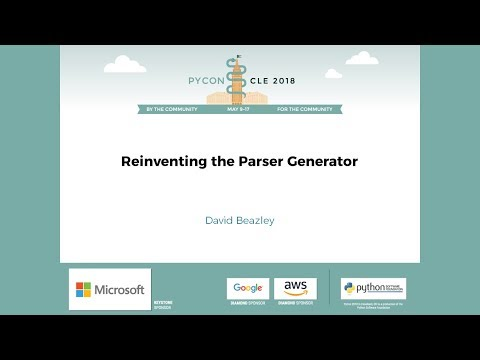

In [2]:
YouTubeVideo('zJ9z6Ge-vXs')

### TODO Watch this Youtube video sequence (total 5 segments)
that talks about designing a calculator.

Direct path is https://youtu.be/Hh49BXmHxX8

In [ ]:
YouTubeVideo('Hh49BXmHxX8')

### TODO Study this Arithmetic Expression Parser

The goal is to discover differences with real parsers in the field.

Background information about a calculator following these CFG rules:

```
Rule 0     S -> expression
Rule 1     expression -> expression PLUS term
Rule 2     expression -> expression MINUS term
Rule 3     expression -> term
Rule 4     term -> term TIMES factor
Rule 5     term -> term DIVIDE factor
Rule 6     term -> factor
Rule 7     factor -> innerfactor EXP factor
Rule 8     factor -> innerfactor
Rule 9     innerfactor -> UMINUS innerfactor
Rule 10    innerfactor -> LPAREN expression RPAREN
Rule 11    innerfactor -> NUMBER
```

These rules are implemented in the following parser.

Note the use of:
* "~" (tilde) for unary minus,
* "-" (regular minus) for binary infix minus, and
* "^" for exponentiation.

In [3]:
# Following ideas from http://www.dabeaz.com/ply/example.html heavily
tokens = ('NUMBER','LPAREN','RPAREN','PLUS','MINUS','TIMES','DIVIDE','UMINUS','EXP') 

# Tokens
t_PLUS    = r'\+'
t_MINUS   = r'\-'
t_TIMES   = r'\*'
t_DIVIDE  = r'\/'
t_LPAREN  = r'\('
t_RPAREN  = r'\)' 
t_UMINUS  = r'\~' 
t_EXP     = r'\^'

# parsing + semantic actions in one place!
def t_NUMBER(t):
    r'\d+'
    try:
        t.value = int(t.value)
    except ValueError:
        print("Integer value too large %d", t.value)
        t.value = 0
    return t

# Ignored characters
t_ignore = " \t"

def t_newline(t):
    r'\n+'
    t.lexer.lineno += t.value.count("\n")
    
def t_error(t):
    print("Illegal character '%s'" % t.value[0])
    t.lexer.skip(1)

In [4]:

def p_expression_1(t):
    'expression : expression PLUS term'
    #
    t[0] = (t[1][0] + t[3][0],
            attrDyadicInfix("+", t[1][1], t[3][1]))   
    
def p_expression_2(t):
    'expression : expression MINUS term'
    #
    t[0] = (t[1][0] - t[3][0],
            attrDyadicInfix("-", t[1][1], t[3][1]))   
    
def p_expression_3(t):
    'expression : term'
    #
    t[0] = t[1]  
    
# Consult this excellent reference for info on precedences
# https://www.cs.utah.edu/~zachary/isp/worksheets/operprec/operprec.html
    
    
def p_term_1(t):
    'term :  term TIMES factor'
    #
    t[0] = (t[1][0] * t[3][0],
            attrDyadicInfix("*", t[1][1], t[3][1])) 

    
def p_term_2(t):
    'term :  term DIVIDE factor'
    #
    if (t[3][0] == 0):
        print("Error, divide by zero!")
        t[3][0] = 1 # fix it
    t[0] = (t[1][0] / t[3][0],
            attrDyadicInfix("/", t[1][1], t[3][1]))


def p_term_3(t):
    'term :  factor'
    #
    t[0] = t[1]  

def p_factor_1(t):
    'factor : innerfactor EXP factor'
    #
    t[0] = (t[1][0] ** t[3][0],
            attrDyadicInfix("^", t[1][1], t[3][1])) 

def p_factor_2(t):
    'factor : innerfactor'
    #
    t[0] = t[1]
    
def p_innerfactor_1(t):
    'innerfactor : UMINUS innerfactor'
    #
    ast  = ('~', t[2][1]['ast'])
    
    nlin = t[2][1]['dig']['nl']
    elin = t[2][1]['dig']['el']
    
    rootin = nlin[0]

    root = NxtStateStr("~E_") 
    left = NxtStateStr("~_")

    t[0] =(-t[2][0], 
           {'ast' : ast,
            'dig' : {'nl' : [ root, left ] + nlin, # this order important for proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin) ]
                    }})

    
def p_innerfactor_2(t):
    'innerfactor : LPAREN expression RPAREN'
    #
    ast  = t[2][1]['ast']
    
    nlin = t[2][1]['dig']['nl']
    elin = t[2][1]['dig']['el']
    
    rootin = nlin[0]
    
    root = NxtStateStr("(E)_")
    left = NxtStateStr("(_")
    right= NxtStateStr(")_")
    
    t[0] =(t[2][0],
           {'ast' : ast,
            'dig' : {'nl' : [root, left] + nlin + [right], #order important f. proper layout!
                     'el' : elin + [ (root, left),
                                     (root, rootin),
                                     (root, right) ]
                    }})

def p_innerfactor_3(t):
    'innerfactor : NUMBER'
    #
    strn = str(t[1])
    ast  = ('NUMBER', strn)           
    t[0] =(t[1],
           { 'ast' : ast,
             'dig' : {'nl' : [ strn + NxtStateStr("_") ],
                      'el' : []
                     }})


def p_error(t):
    print("Syntax error at '%s'" % t.value)

#--
    
def attrDyadicInfix(op, attr1, attr3):
    ast  = (op, (attr1['ast'], attr3['ast']))
    
    nlin1 = attr1['dig']['nl']
    nlin3 = attr3['dig']['nl']
    nlin  = nlin1 + nlin3
    
    elin1 = attr1['dig']['el']
    elin3 = attr3['dig']['el']
    elin  = elin1 + elin3
    
    rootin1 = nlin1[0]
    rootin3 = nlin3[0]    
    
    root   = NxtStateStr("E1"+op+"E2"+"_") # NxtStateStr("$_")
    left   = rootin1
    middle = NxtStateStr(op+"_")
    right  = rootin3
    
    return {'ast' : ast,
            'dig' : {'nl' : [ root, left, middle, right ] + nlin,
                     'el' : elin + [ (root, left),
                                     (root, middle),
                                     (root, right) ]
                     }}

#===
# This is the main function in this Jove file.  
#===

def parseExp(s):
    """In: a string s containing a regular expression.
       Out: An attribute triple consisting of
            1) An abstract syntax tree suitable for processing in the derivative-based scanner
            2) A node-list for the parse-tree digraph generated. Good for drawing a parse tree 
               using the drawPT function below
            3) An edge list for the parse-tree generated (again good for drawing using the
               drawPT function below)
    """
    mylexer  = lex()
    myparser = yacc()
    pt = myparser.parse(s, lexer = mylexer)
    
    # print('parsed result  is ', pt)
    # (result, ast, nodes, edges)
    return (pt[0], pt[1]['ast'], pt[1]['dig']['nl'], pt[1]['dig']['el'])

def drawPT(ast_rslt_nl_el, comment="PT"):
    """Given an (ast, nl, el) triple where nl is the node and el the edge-list,
       draw the Parse Tree by returning a dot object.
    """
    (rslt, ast, nl, el) = ast_rslt_nl_el
    
    print("Result calculated = ", rslt)
    print("Drawing AST for ", ast)
    
    dotObj_pt = Digraph(comment)
    dotObj_pt.graph_attr['rankdir'] = 'TB'
    for n in nl:
        prNam = n.split('_')[0]
        dotObj_pt.node(n, prNam, shape="oval", peripheries="1")
    for e in el:
        dotObj_pt.edge(e[0], e[1])
    return dotObj_pt

#### TODO Answer the question

How does the above calculator above parse ```~2^2```?

Result calculated =  4
Drawing AST for  ('^', (('~', ('NUMBER', '2')), ('NUMBER', '2')))


Generating LALR tables


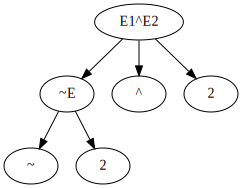

In [5]:
drawPT(parseExp('~2^2'))

#### TODO Answer the question

How does this calculator differ from Python?

In [8]:
# Python evaluation
-2 ** 2

-4

In [12]:
parseExp('~2^2')

Generating LALR tables


(4,
 ('^', (('~', ('NUMBER', '2')), ('NUMBER', '2'))),
 ['E1^E2_29', '~E_26', '^_30', '2_28', '~E_26', '~_27', '2_25', '2_28'],
 [('~E_26', '~_27'),
  ('~E_26', '2_25'),
  ('E1^E2_29', '~E_26'),
  ('E1^E2_29', '^_30'),
  ('E1^E2_29', '2_28')])

The calculator actually returns the correct result. The python code isn't returning 4 like it should and instead doesn't consider the case of multiplying a negative number with a negative number an even amount of times. This calculator handles that correctly. This might be a operator order of operations problem.

#### TODO Answer the question

How would you parenthesize the ```-2 ** 2``` expression so that Python would give the same answer?

In [13]:
# Put your answer here
(-2) ** 2

4

#### Now look at how ```2^~3^~4``` is parsed.

Result calculated =  1.008594091576999
Drawing AST for  ('^', (('NUMBER', '2'), ('^', (('~', ('NUMBER', '3')), ('~', ('NUMBER', '4'))))))


Generating LALR tables


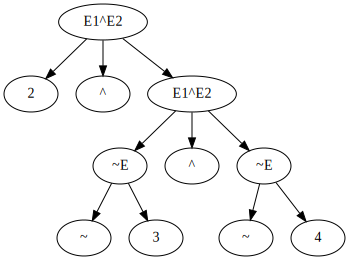

In [14]:
drawPT(parseExp("2^~3^~4"))

#### Do the same compare/contrast exercise for this longer expression.

I.e., parse it, draw its parse tree, parenthesize the Python version so they match.

In [15]:
 # The above expression in Python's syntax is below. See what it produces!
2**-3**-4

0.9914791374956781

Yet again the wrong answer, due to order of operations of the unary minus sign.

In [16]:
2**(-3)**(-4)

1.008594091576999

#### Do the same compare/contrast exercise for this even longer expression.

Result calculated =  1.1249999999999991
Drawing AST for  ('-', (('/', (('*', (('/', (('*', (('NUMBER', '6'), ('NUMBER', '3'))), ('NUMBER', '4'))), ('~', ('NUMBER', '5')))), ('-', (('-', (('-', (('+', (('NUMBER', '2'), ('NUMBER', '3'))), ('NUMBER', '4'))), ('NUMBER', '5'))), ('*', (('/', (('NUMBER', '6'), ('NUMBER', '7'))), ('~', ('NUMBER', '8')))))))), ('~', ('NUMBER', '9'))))


Generating LALR tables


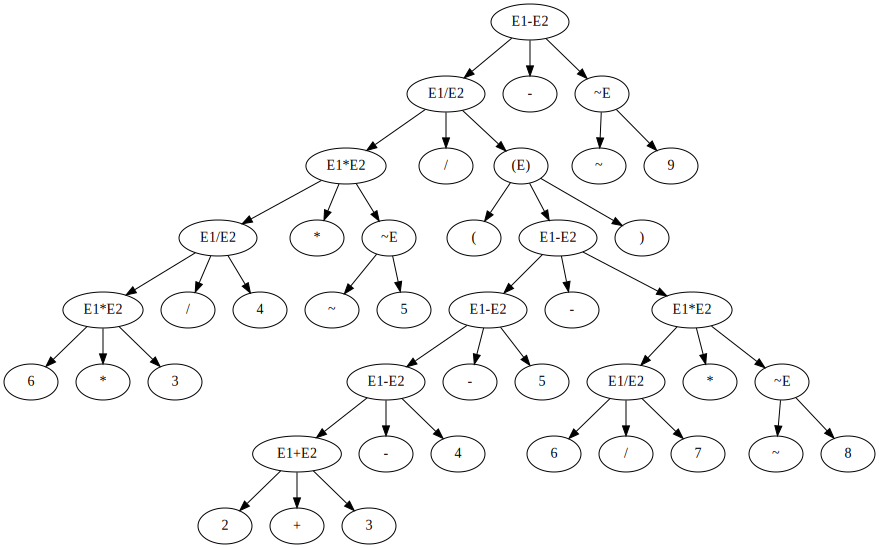

In [19]:
drawPT(parseExp("6*3/4*~5/(2+3-4-5-6/7*~8)-~9"))

In [20]:
6*3/4*-5/(2+3-4-5-6/7*-8)--9

1.1249999999999991

Both the standard python syntax and the calculator returned the same answer without messing with the original syntax of the python operator when converted from the calculator syntax. The unary minus order of operations problem seems to occur only with exponentian.

#### TODO Answer the question

Except for expressions with unary minus and exponentiation, are the two parsers in complete agreement?

Based on these experiments, yes.

#### TODO Answer the question

With regard to parsing arithmetic expressions, how does Python differ from C++ and Google Sheets?

Point out the similarities and differences between C++, Python, and Google Sheets when it comes to handling these expressions. Write a few sentences talking about similarities and a few sentences about the differences.

Specifically, answer these two questions for each of C++, Python, and Google Sheets:
1. What is the associativity of exponentiation, left-associative or right-associative?
2. Which is handled first, unary minus or exponentiation?


Well, in C++, these is no proper operator for exponentian. You need to use a seperate function to do that. You could expand it out to use multiple * signs or a loop if you were to do it yourself. 